# Tusya Detection. Object Recognition.

## Installing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import time
import os

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold
from skimage.feature import hog

import PIL
import cv2

sns.set_theme(palette='pastel')
plt.rcParams["axes.grid"] = False

## Loading the Dataset

In [2]:
def load_images(path):
    images = []
    os.chdir(path)
    for img_name in os.listdir('.'):
        img = np.array(PIL.Image.open(img_name))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, MIN_SIZE)
        images.append(img)
    os.chdir('..')
    return images

In [3]:
def get_hog(img):
    img_features, visual = hog(img, pixels_per_cell = PIXELS_PER_CELL,
                               cells_per_block = CELLS_PER_BLOCK,
#                                block_norm = BLOCK_NORM,
                               visualize = True)
    return np.array(img_features), visual

In [4]:
path1 = 'PositiveTusya'
path2 = 'NegativeTusya'
MIN_SIZE = (150,200)

PIXELS_PER_CELL = (15,15)
CELLS_PER_BLOCK = (1,1)
BLOCK_NORM = 'L2'

In [5]:
positive_tusya = load_images(path1)
negative_tusya = load_images(path2)

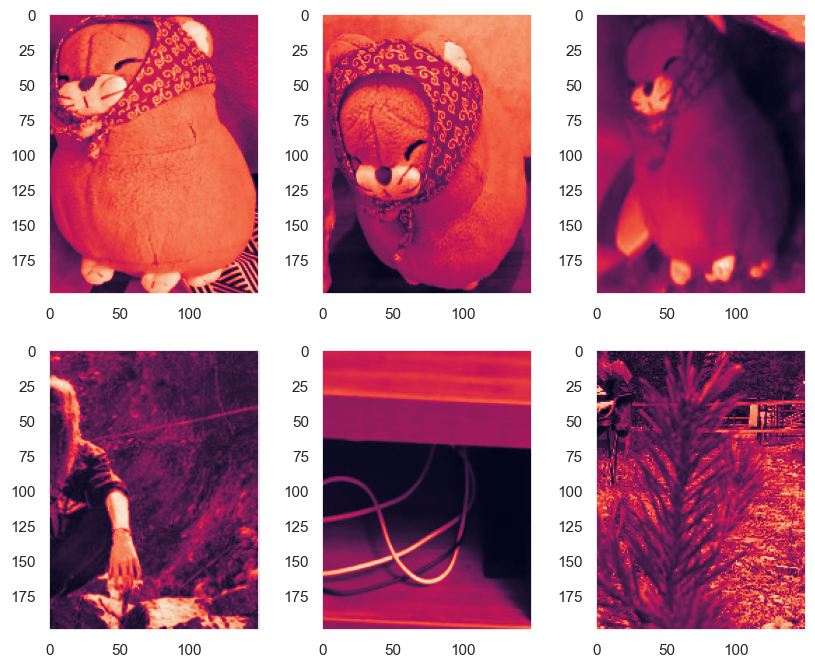

In [6]:
fig, axs = plt.subplots(2,3, figsize=(10,8))
axs = axs.flatten()
for i in range(3):
    axs[i].imshow(positive_tusya[random.choice(range(len(positive_tusya)))])
    axs[i+3].imshow(negative_tusya[random.choice(range(len(negative_tusya)))])

## Histogram of Oriented Gradients (HOG)

In [7]:
pos_features = np.array([get_hog(x)[0] for x in positive_tusya])
neg_features = np.array([get_hog(x)[0] for x in negative_tusya])
pos_labels = np.ones(pos_features.shape[0])
neg_labels = np.zeros(neg_features.shape[0])

X = np.concatenate([pos_features, neg_features])
y = np.concatenate([pos_labels, neg_labels])

print('Shape of Positives:', pos_features.shape)
print('Shape of Negatives:', neg_features.shape)
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of Positives: (79, 1170)
Shape of Negatives: (432, 1170)
Shape of X: (511, 1170)
Shape of y: (511,)


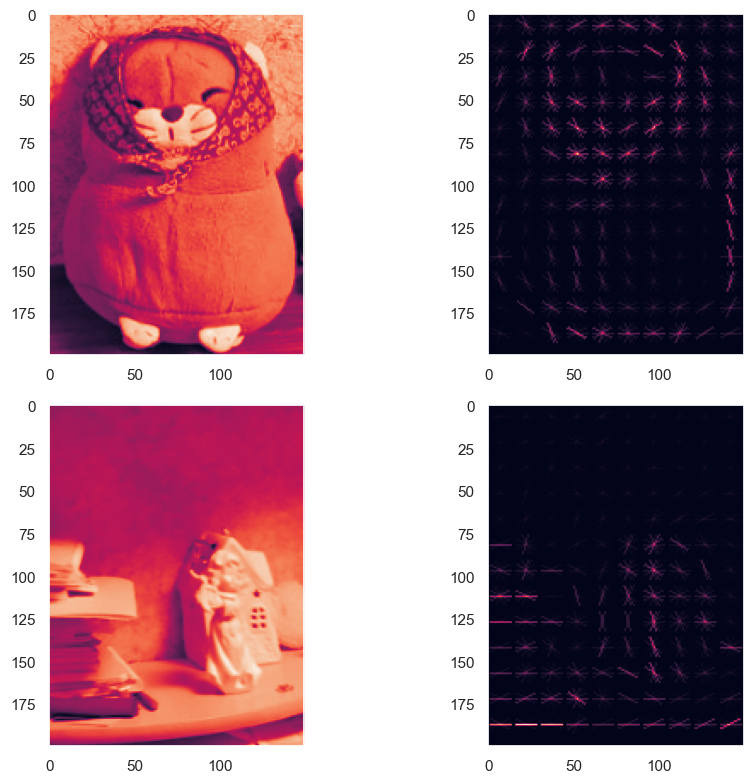

In [8]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

for i, dataset in zip(range(2), (positive_tusya, negative_tusya)):
    sample_index = random.choice(range(len(dataset)))
    features, visual_pos = get_hog(dataset[sample_index])
    
    axs[i, 0].imshow(dataset[sample_index])
    axs[i, 1].imshow(visual_pos)
plt.tight_layout()

## Prior Model Testing

In [9]:
skf = StratifiedKFold(4, shuffle=True, random_state=582002)

train_index, test_index = next(skf.split(X,y))
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(511, 1170)
(383, 1170)
(128, 1170)


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       108
         1.0       1.00      0.90      0.95        20

    accuracy                           0.98       128
   macro avg       0.99      0.95      0.97       128
weighted avg       0.98      0.98      0.98       128



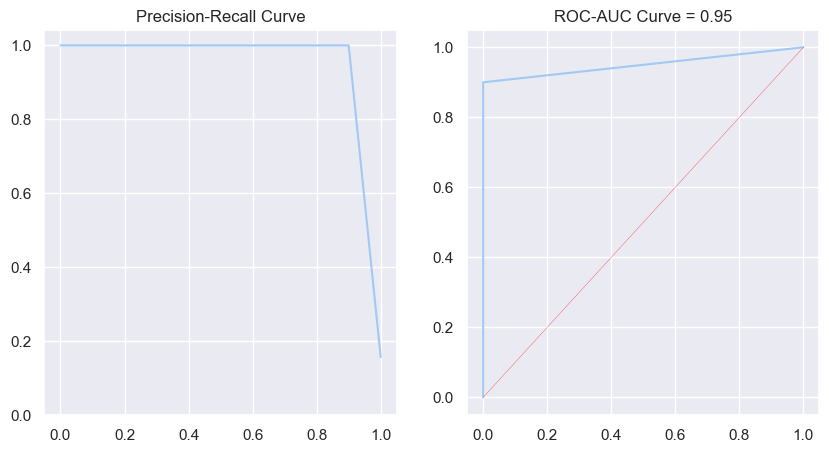

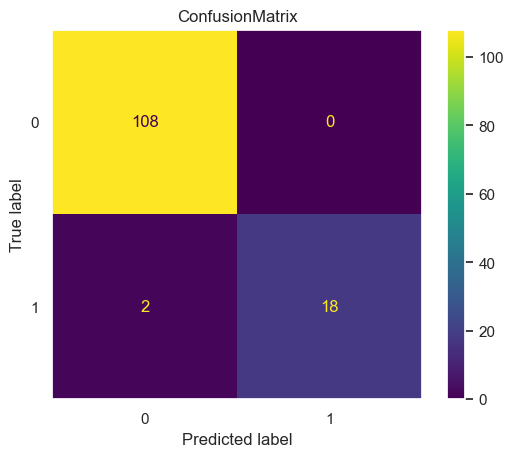

In [10]:
svc = SVC(kernel='rbf').fit(X_train, y_train)
preds = svc.predict(X_test)

cm = confusion_matrix(y_test, preds)
CM = ConfusionMatrixDisplay(cm)
fpr, tpr, thresholds = roc_curve(y_test, preds)
prec, rec, thresholds = precision_recall_curve(y_test, preds)

print(classification_report(y_test, preds))

plt.rcParams["axes.grid"] = True
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(rec, prec)
plt.yticks(np.arange(0,1.1, .2))
plt.title('Precision-Recall Curve')

plt.subplot(122)
plt.plot(fpr, tpr)
sns.lineplot(x=[0,1],y=[0,1], color='red', linewidth=0.2)
plt.title(f'ROC-AUC Curve = {round(roc_auc_score(y_test, preds), 2)}')

CM.plot()
plt.title('ConfusionMatrix')
plt.grid(False)
plt.show()

In [11]:
#false negative is TEST-PREDS == 1, false positive is TEST-PREDS == -1
#true positive or true negative will be TEST-PREDS == 0
false = y_test - preds != 0
false_index = test_index[false]
false_index

array([33, 52])

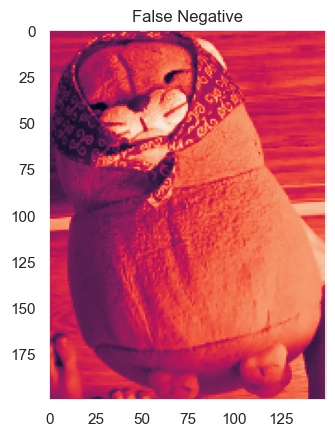

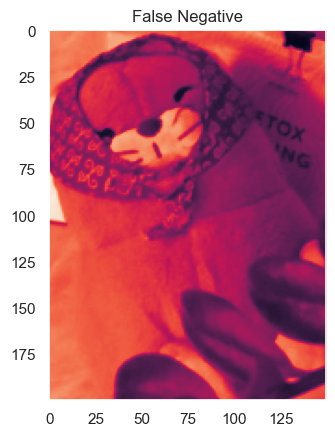

In [12]:
plt.rcParams['axes.grid'] = False
for i in false_index:
    if i < len(positive_tusya) - 1:
        plt.imshow(positive_tusya[i])
        plt.title('False Negative')
        plt.show()
    else:
        plt.imshow(negative_tusya[i])
        plt.title('False Positive')
        plt.show()

In [13]:
svc = SVC(kernel='rbf').fit(X, y)

## Object Recognition Algorithm

* The window with the size `MIN_SIZE` slides over the picture creating HOG features. After each full scan, the window size increases. Increasing the window size allows us to recognize Tusya of any size.
* Due to the fact our window is increasing its own size after each image scanning we must to resize each window image to `MIN SIZE` so that our model can work.
* Our model gets HOG features and gives a prediction of whether there is Tusya in the current window.
* If it's there, then we flag the position of current window in the mask array.

<img src='https://github.com/ssensse/ds_labs/blob/main/Tusya_ObjectRecognition/window_slide_illustration.png?raw=true'>

In [14]:
def detect(image, min_win_size=MIN_SIZE, step=15, window_growth=10, print_time=True):

    mask = np.zeros(image.shape[:2])
    hIm, wIm = image.shape[:2]
    
    # Simple calculations below find maximum window size preserving proportions of rectangle
    max_win_height = min_win_size[1] * (hIm // min_win_size[1])
    max_win_width = int(max_win_height * (min_win_size[0] / min_win_size[1]))
    # Window size is increasing in geometric progression
    width_range = np.int64(np.geomspace(min_win_size[0], max_win_height, window_growth))
    height_range = np.int64(np.geomspace(min_win_size[1], max_win_height, window_growth))

    # After each scanning window increases
    for win_width, win_height in zip(width_range, height_range):
        start_time = time.time()
        # w1 is the left coordinate of window width in the image, w2 is the right one
        for w1, w2 in zip(range(0, wIm - win_width, step), range(win_width, wIm, step)):
            # h1 is the top coordinate, h2 is the bottom
            for h1, h2 in zip(
                range(0, hIm - win_height, step), range(win_height, hIm, step)):

                window = image[h1:h2, w1:w2]
                resized_window = cv2.resize(window, MIN_SIZE)
                features_of_window = hog(
                    resized_window,
                    pixels_per_cell=PIXELS_PER_CELL,
                    cells_per_block=CELLS_PER_BLOCK)
                
                prediction = svc.predict([features_of_window])
                if prediction == 1:
                    mask[h1:h2, w1:w2] += 10

        end_time = time.time()
        if print_time:
            print("Iteration duration:", round(end_time - start_time), "sec")

    return mask

In [15]:
def get_image(path, channel='RGB'):
    original_image = np.array(PIL.Image.open(path))
    hIm, wIm = original_image.shape[:2]

    if hIm > 2000:
        image = cv2.resize(original_image, (wIm//3, hIm//3))
    else:
        image = original_image.copy()
    
    if channel == "RGB":
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image

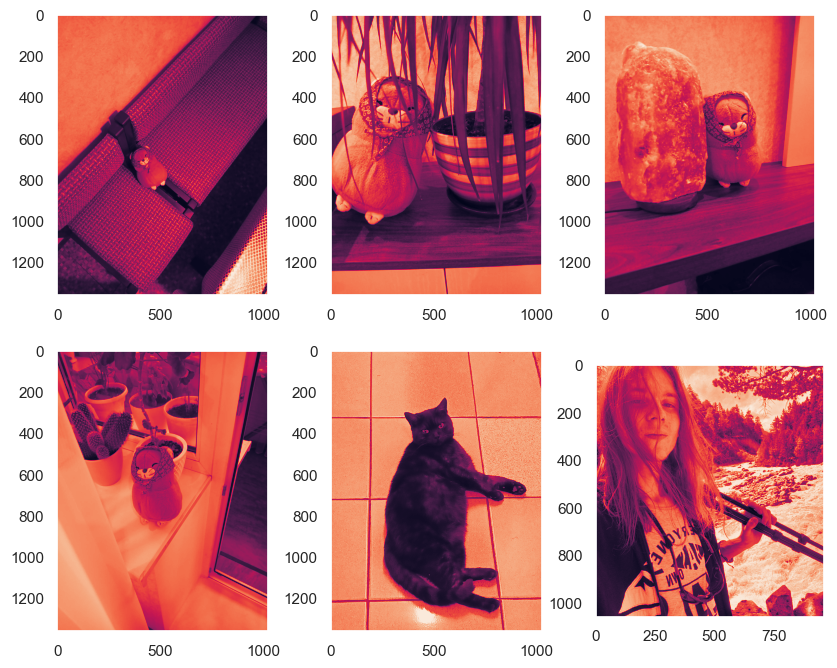

In [16]:
paths = ['PositiveTusyaOriginal/IMG20240303174750.jpeg', 
         'PositiveTusyaOriginal/IMG20240303174404.jpeg',
         'PositiveTusyaOriginal/IMG20240303174311.jpeg',
         'PositiveTusyaOriginal/IMG20240303174218.jpeg',
         'C:/Users/79283/Desktop/Новая папка/IMG20231007002834.jpg',
         'C:/Users/79283/Desktop/Разное/Фотки/photo3.jpg']

images = [get_image(path) for path in paths]

fig, axs = plt.subplots(2, 3, figsize=(10,8))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(images[i])
plt.show()

In [17]:
# hIm, wIm = image.shape[:2]
# max_win_height = MIN_SIZE[1] * (hIm // MIN_SIZE[1])
# max_win_width = round(max_win_height * (MIN_SIZE[0] / MIN_SIZE[1]))
# width_range = np.int16(np.geomspace(MIN_SIZE[0], max_win_width, 10))
# height_range = np.int16(np.geomspace(MIN_SIZE[1], max_win_height, 10))
# print(MIN_SIZE)
# print(max_win_height, height_range)
# print(max_win_width, width_range)

In [18]:
masks = [detect(img, print_time=False) for img in tqdm(images)]

100%|██████████| 6/6 [11:41<00:00, 116.85s/it]


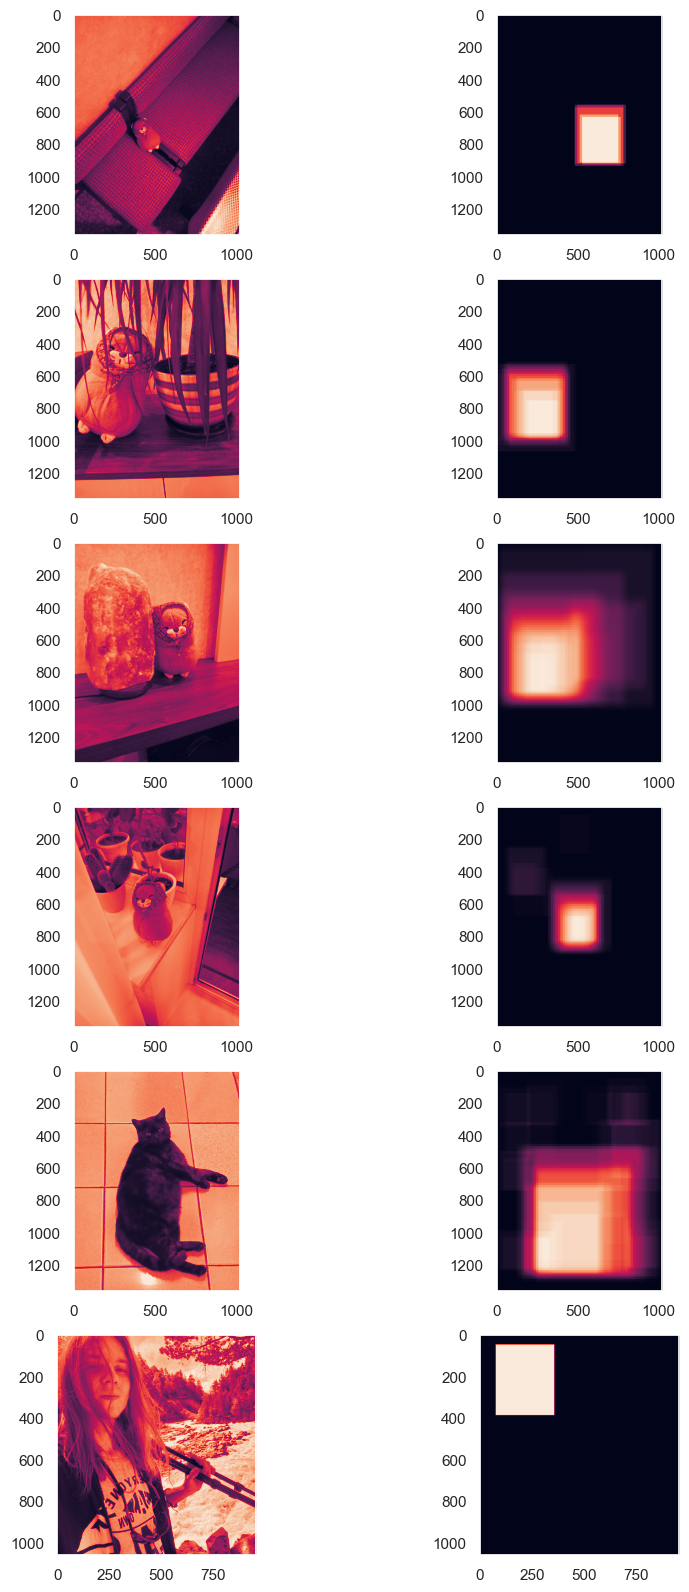

In [19]:
fig, axs = plt.subplots(6, 2, figsize=(10,20))
for i, (img, mask) in enumerate(zip(images, masks)):
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(mask)
plt.show()

Seems like algorithm can recognize some shapes that are related to shape of Tusya's body, head or headband.

Such rounded shapes as a head, a cat's body, a cactus can confuse our model.

Algorithm has low quality for the following reasons:
1. SVC + HOG isn't effective way for object recognition. Nowadays we're using CNN and other NN-based models for object recognition.
2. We don't have Tusya images enough to train SVC.

Probably algorithm can work better if we consider the pictures in a certain format:
1. Tusya has to stay straight in every picture.
2. No strong shadows fall on her.
3. Each picture will have Tusya's face.